# 402 RNN

为了效率，这是从莫烦的github直接copy来的文件

为了保证“时间x效率=收获”中的收获因为COPY这个操作不减少，需要在效率增加的情况下控制时间这个变量至少不变，或者说，需要研究的更加深入，提出更多的问题，回答更多的问题。

需要注意的是，这一个文件虽然叫做RNN，而且用到了LSTM，但是实际上并没有使用LSTM的特性，而是将LSTM当作了一个普通的神经网络用，而没有用到RNN特有的状态传递。

View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* matplotlib


In [51]:
import torch
from torch import nn
# from torch.autograd import Variable ## Variable这种表达方式已经被完全舍弃了，现在所有的tensor对象都是Variable的
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
torch.manual_seed(1)    # reproducible 设置torch的随机数，这个操作会使得多次实验的结果差距不会太大

In [53]:
# Hyper Parameters 超参数
EPOCH = 1               # 学习训练集n次，为了省时间这里设置为了1 epoch = 轮
BATCH_SIZE = 64         # 分片训练实际上是给代码提高了一个层次的复杂度。  ## 但是它能带来一点模型性能上的提升，所以说就还是使用batch的。
TIME_STEP = 28          # rnn time step / image height RNN特有的在时间维度上的设置
INPUT_SIZE = 28         # rnn input size / image width 不同于CNN每次输入是5x5的矩阵，RNN每次输入一行的向量，即1x28
LR = 0.01               # learning rate 学习率
DOWNLOAD_MNIST = False   # set to True if haven't download the data

In [54]:
# Mnist digital dataset
# MNIST这个对象，或者说，torchvision.datasets.MNIST，这个对象，是什么样子的呢？
# MNIST的详细说明在 https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# MNIST的属性有：“data target”
# MNIST的方法有：“__getitem__ __len__”
# 总结：MNIST的封装做的很差，现在看来不改进的原因是能够很好的支持历史遗留代码，对历史有很高的兼容性。
train_data = dsets.MNIST(
    root='./data',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
                                        # transform这个参数只在使用 __getitem__ 正规获取元素时才起作用。
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)
print(f"MNIST的type: {type(train_data)}，\n"
      f"MNIST的getitem的type：{type(train_data.__getitem__(0))}，\n"
      f"MNIST的getitem()[0]的type：{type(train_data.__getitem__(0)[0])}，（数据data）\n"
      f"MNIST的getitem()[0]的shape：{train_data.__getitem__(0)[0].shape}，（数据data）\n"
      f"MNIST的getitem()[1]的type：{type(train_data.__getitem__(0)[1])}，（标签target）\n"
      f"train_data中的数据量：{train_data.__len__()}")


MNIST的type: <class 'torchvision.datasets.mnist.MNIST'>，
MNIST的getitem的type：<class 'tuple'>，
MNIST的getitem()[0]的type：<class 'torch.Tensor'>，（数据data）
MNIST的getitem()[0]的shape：torch.Size([1, 28, 28])，（数据data）
MNIST的getitem()[1]的type：<class 'int'>，（标签target）
train_data中的数据量：60000


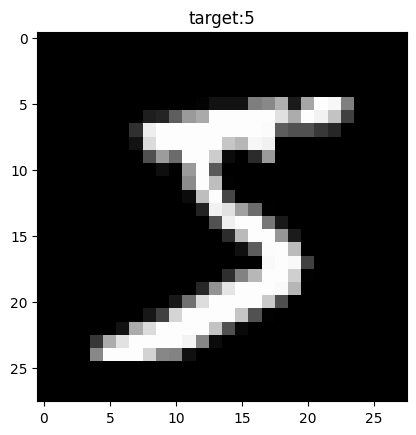

In [55]:
# Display data as an image
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# 只有使用__getitem__是正规的获取数据的方法，但这里获取的数据是transform过的
# cmap指定为gray会指示imshow按照灰度打印，而因为没有指示gray灰度的上下界，尽管已经 transform 了，还是会对灰度的值进行自动拉伸
plt.imshow(train_data.__getitem__(0)[0].squeeze(dim=0), cmap='gray')
# plt.imshow(train_data.data[0], cmap='gray') # 使用这个方法也可以获取image的数据，这个方法获取的数据是没有经过 transform 的，可以发现两个方法展示的图像是相同的。
plt.title(f'target:{train_data.targets[0]}')
plt.show()

In [56]:
# Data Loader for easy mini-batch return in training
# https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# DataLoader是个类似于迭代器的东西
# 此处，DataLoader的输入是一个 MNIST 对象，而MNIST对象的正规数据获取方法为__getitem__(index)
# DataLoader的输出是[BATCH_SIZE, item]，也就是对MNIST的item进行了一个根据BATCH_SIZE的打包
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
for x in enumerate(train_loader):
    print(f"returx type: {type(x)},len:{x.__len__()}\n"
          f"    step x[0] type: {type(x[0])},step:{x[0]}\n"
          f"    elem x[1] type: {type(x[1])},len:{x[1].__len__()}\n"
          f"        trainx[1][0] type: {type(x[1][0])},{x[1][0].shape}\n"
          f"        targex[1][1] type: {type(x[1][1])},{x[1][1].shape}\n")
    break

returx type: <class 'tuple'>,len:2
    step x[0] type: <class 'int'>,step:0
    elem x[1] type: <class 'list'>,len:2
        trainx[1][0] type: <class 'torch.Tensor'>,torch.Size([64, 1, 28, 28])
        targex[1][1] type: <class 'torch.Tensor'>,torch.Size([64])



In [57]:
# 设置测试集，选择 2000 个样本用来测试
test_data = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
print("data shape:", test_data.data.shape)
test_x = test_data.data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
print("test_x shape:",test_x.shape)

print("target shape:", test_data.targets.shape)
test_y = test_data.targets[:2000]    # covert to numpy array
print("test_y shape:",test_y.shape)

data shape: torch.Size([10000, 28, 28])
test_x shape: torch.Size([2000, 28, 28])
target shape: torch.Size([10000])
test_y shape: torch.Size([2000])


In [58]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        # https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer 没搞懂这个参数有什么作用
            # LSTM 会自动根据传入数据所指明的batch的大小来批量训练
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state (None所占的位置是用来传递RNN的状态的，h_n和h_c中，前者是支线（隐藏层）记忆，后者是主线（细胞）记忆)
                                                # 如果想将记忆传入，则可以将这里改成 rnn(x, (h_n, h_c))

        # choose r_out at the last time step 取out的最后一个时间点用来做预测并计算loss
        out = self.out(r_out[:, -1, :])
        return out

In [59]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [60]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters 典型的优化算法
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted 典型的分类Loss计算方法

In [82]:
# training and testing
DEBUG_epoch = False
for epoch in range(EPOCH):
    # https://docs.python.org/zh-cn/3/library/functions.html#enumerate
    # enumerate的输入：传入一个序列，或者是迭代器
    # enumerate 的输出：输出的时候，调用传入对象的 __next__() 方法，返回一个元组
    # 此处的 enumerate 调用了 train_loader 或者说 torch.utils.data.DataLoader 这个对象的  __next__() 方法
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        # reshape x to (batch, time_step, input_size)
        # 其中view(-1, _, _) 中的-1意味着让torch自动推导这一个维度的大小，
        # 不直接指明为BATCH_SIZE是因为不能确保训练个数一定是BATCH_SIZE的整数倍
        # x的一般形式为[64, 1, 28, 28]
        # b_x的一般形式为[64, 28, 28]，其中的64会被rnn自动识别为batch参数（因为指明了batchfirst），所以一次调用rnn会训练64张图
        b_x = x.view(-1, TIME_STEP, INPUT_SIZE)
        b_y = y                                         # batch y b_y的shape为64
        if DEBUG_epoch :
            print("b_y.shape:", b_y.shape)

        output = rnn(b_x)                               # rnn output 训练模型 output的size为[64,10]
        if DEBUG_epoch :
            print("output.shape:",output.shape)

        loss = loss_func(output, b_y)                   # cross entropy loss 计算损失

        optimizer.zero_grad()                           # clear gradients for this training step 清空梯度
        loss.backward()                                 # backpropagation, compute gradients 计算梯度
        optimizer.step()                                # apply gradients 应用梯度

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size) 测试模型
            # https://docs.pytorch.org/docs/stable/generated/torch.max.html
            # max(数据，维度)，即在某个维度上只保留一个最大值
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            if DEBUG_epoch:
                print(f"\n"
                      f"torch.max().__len__():{torch.max(test_output, 1).__len__()}, type: {type(torch.max(test_output, 1))}\n"
                      f"torch.max()[0].size():{torch.max(test_output, 1)[0].size()}, type: {type(torch.max(test_output, 1)[0])}\n"
                      f"torch.max()[0]:{torch.max(test_output, 1)[0]}\n"
                      f"torch.max()[1].size():{torch.max(test_output, 1)[1].size()}, type: {type(torch.max(test_output, 1)[1])}\n"
                      f"torch.max()[1]:{torch.max(test_output, 1)[1]}\n")
            accuracy = sum(pred_y == test_y) / test_y.detach().__len__()
            print('Epoch: ', epoch, '| step: %d' % step, '| train loss: %.4f' % loss, '| test accuracy: %.4f' % accuracy)

        if DEBUG_epoch:
            break


Epoch:  0 | step: 0 | train loss: 1.4637 | test accuracy: 0.4280
Epoch:  0 | step: 50 | train loss: 0.8232 | test accuracy: 0.6570
Epoch:  0 | step: 100 | train loss: 0.5385 | test accuracy: 0.7575
Epoch:  0 | step: 150 | train loss: 0.6552 | test accuracy: 0.8495
Epoch:  0 | step: 200 | train loss: 0.5838 | test accuracy: 0.8850
Epoch:  0 | step: 250 | train loss: 0.3843 | test accuracy: 0.8975
Epoch:  0 | step: 300 | train loss: 0.3177 | test accuracy: 0.8975
Epoch:  0 | step: 350 | train loss: 0.1823 | test accuracy: 0.9270
Epoch:  0 | step: 400 | train loss: 0.0856 | test accuracy: 0.9350
Epoch:  0 | step: 450 | train loss: 0.3067 | test accuracy: 0.9360
Epoch:  0 | step: 500 | train loss: 0.0916 | test accuracy: 0.9435
Epoch:  0 | step: 550 | train loss: 0.3564 | test accuracy: 0.9365
Epoch:  0 | step: 600 | train loss: 0.1377 | test accuracy: 0.9335
Epoch:  0 | step: 650 | train loss: 0.1458 | test accuracy: 0.9380
Epoch:  0 | step: 700 | train loss: 0.1304 | test accuracy: 0.954

In [83]:
# 对训练好的模型进行测试
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) prediction number
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]) real number
